# Explanation Quantification with Quantus - Live coding!

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/understandable-machine-intelligence-lab/Quantus/HEAD?labpath=tutorials%2FTutorial_Introduction_to_AI_Interpretability_Course_2022.ipynb)

Anna Hedström, PhD candidate, TU Berlin

**Introduction to AI Interpretability, 2022**

____
This notebook shows some different types of analysis that can be conducted with Quantus, going from qualitative analysis to quantitative analysis and sensitivity analysis. For this purpose, we use a pre-trained PyTorch MobileNet V3 model and ImageNet dataset. Make sure to have GPUs enabled to speed up computation.






In [ ]:
from IPython.display import clear_output
!pip install torch torchvision captum quantus
clear_output()

In [ ]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pathlib
import random
import copy
import gc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from captum.attr import *
import quantus
import warnings
sns.set() 

# Enable GPU. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
clear_output()

## 1) Preliminaries

### 1.1 Load datasets

We have prepared a small subset of ImageNet images which can be downloaded at: <https://github.com/understandable-machine-intelligence-lab/Quantus/tree/main/tutorials/assets/imagenet_samples/>. Please make sure to download the contents of the folder, that are, the inputs `x_batch.pt`, outputs `y_batch.pt` and segmentation masks `s_batch.pt`. (A description for how to download the full dataset can be found here: <https://image-net.org/download.php>.)

In [ ]:
# Adjust this path.
path_to_files = "drive/MyDrive/Projects/quantus/tutorials/assets/imagenet_samples"

# Load test data and make loaders.
x_batch = torch.load(f'{path_to_files}/x_batch.pt')
y_batch = torch.load(f'{path_to_files}/y_batch.pt')
s_batch = torch.load(f'{path_to_files}/s_batch.pt')
x_batch, s_batch, y_batch = x_batch.to(device), s_batch.to(device), y_batch.to(device)
print(f"{len(x_batch)} matches found.")

17 matches found.


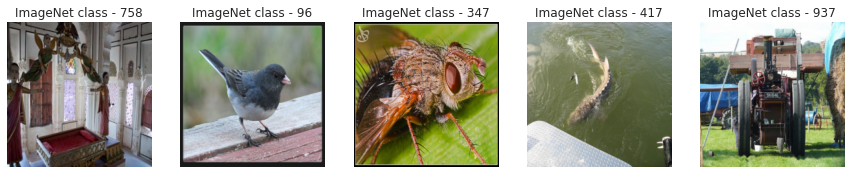

In [ ]:
# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    image = (np.moveaxis(quantus.denormalise(x_batch[i+9].cpu().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1) * 255).astype(np.uint8)
    axes[i].imshow(image, vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class - {y_batch[i+9].item()}")
    axes[i].axis("off")
plt.show()

### 1.2 Load a pre-trained model

In this example we load a pre-trained MobileNet V3 model but it goes without saying that any model works.

In [ ]:
def evaluate_model(model, data, device):
    """Evaluate accuracy of torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, _, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
            
    return np.mean(np.argmax(logits.cpu().numpy(), axis=1) == targets.cpu().numpy())
    
# Load pre-trained MobileNet V3 model.
model = torchvision.models.mobilenet_v3_small(pretrained=True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

### 1.3 Generate explanations

In [ ]:
quantus.AVAILABLE_XAI_METHODS_CAPTUM

# use quantus.AVAILABLE_XAI_METHODS_TF to list available methods for tf-explain

{'Control Var. Constant',
 'Control Var. Random Uniform',
 'Control Var. Sobel Filter',
 'FeatureAblation',
 'LayerGradCam',
 'Gradient',
 'GradientShap',
 'InputXGradient',
 'IntegratedGradients',
 'Occlusion',
 'Saliency'}

In [ ]:
# Use Quantus?
a_batch = quantus.explain(model=model, inputs=x_batch, targets=y_batch, **{"method:": "Saliency", "device": device})

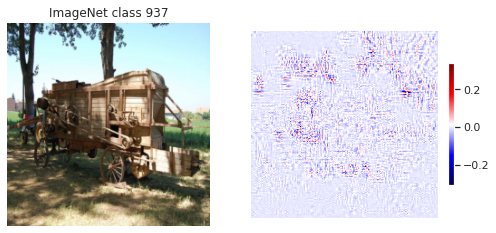

In [ ]:
# Visualise.
index = random.randint(0, len(x_batch)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
image = (np.moveaxis(quantus.denormalise(x_batch[index].cpu().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1) * 255).astype(np.uint8)
axes[0].imshow(image, vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch[index].item()}")
exp = axes[1].imshow(a_batch[index].reshape(224, 224), cmap="seismic") 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show();

#### 1.3.1 Write own explainer functions to use with Quantus

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely completely customised explainer functions. All necessary source code is pasted below.

In [ ]:
def explainer_wrapper(**kwargs):
    """Wrapper for explainer functions."""
    if kwargs["method"] == "Saliency":
        return saliency_explainer(**kwargs)
    elif kwargs["method"] == "IntegratedGradients":
        return intgrad_explainer(**kwargs)
    elif kwargs["method"] == "GradientShap":
        return gradshap_explainer(**kwargs)
    else:
        raise ValueError("Pick an explaination function that exists.")


def saliency_explainer(
    model, inputs, targets, abs=False, normalise=False, *args, **kwargs
) -> np.array:
    """Wrapper aorund captum's Saliency implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
            .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
            .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = (
            torch.as_tensor(targets).long().to(kwargs.get("device", None))
        )  # inputs = inputs.reshape(-1, 3, 224, 224)

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        Saliency(model)
        .attribute(inputs, targets, abs=abs)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def intgrad_explainer(
    model, inputs, targets, abs=False, normalise=False, *args, **kwargs
) -> np.array:
    """Wrapper aorund captum's Integrated Gradients implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
            .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
            .to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        IntegratedGradients(model)
        .attribute(
            inputs=inputs,
            target=targets,
            baselines=torch.zeros_like(inputs),
            n_steps=10,
            method="riemann_trapezoid",
        )
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def gradshap_explainer(
    model, inputs, targets, abs=False, normalise=False, *args, **kwargs
) -> np.array:
    """Wrapper aorund captum's GradShap implementation."""

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs)
            .reshape(
                -1,
                kwargs.get("nr_channels", 3),
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
            .to(kwargs.get("device", None))
        )

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    baselines = torch.zeros_like(inputs).to(kwargs.get("device", None))
    explanation = (
        GradientShap(model)
        .attribute(inputs=inputs, target=targets, baselines=baselines)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    if normalise:
        explanation = quantus.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

In [ ]:
# Produce explanations and empty cache to to survive memory-wise.

# Saliency.
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = saliency_explainer(model=model.cpu(),
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )
# GradShap.
gc.collect()
torch.cuda.empty_cache()
a_batch_gradshap = gradshap_explainer(model=model.cpu(), 
                                    inputs=x_batch,
                                    targets=y_batch, 
                                    **{"device": device},
                                    )
# Integrated Gradients.
gc.collect()
torch.cuda.empty_cache()
a_batch_intgrad = intgrad_explainer(model=model.cpu(),
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )

# Save explanations to file.
explanations = {
    "Saliency": a_batch_saliency,
    "GradientShap": a_batch_gradshap,
    "IntegratedGradients": a_batch_intgrad,
}

### 1.4 Qualitative analysis

Using some handy Quantus functionality like `quantus.normalise_by_negative`and `quantus.denormalise`.

In [ ]:
# Plotting configs.
colours_order = ["#008080", "#FFA500", "#124E78", "#d62728"]
methods_order = ["Saliency (SA)", "GradientShap (GS)", "Integrated\nGradients (IG)"]

plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
include_titles = True

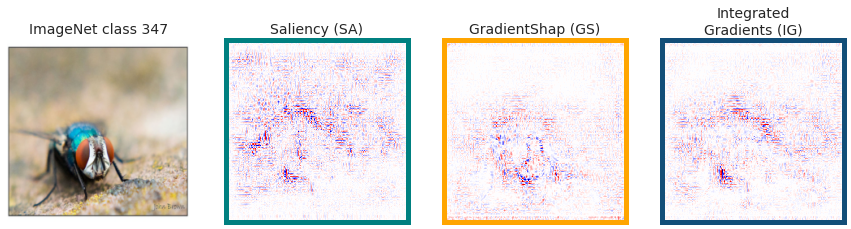

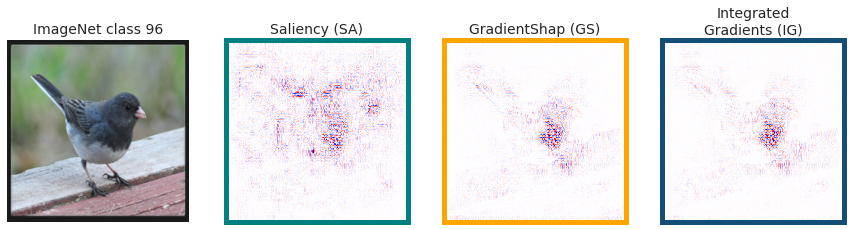

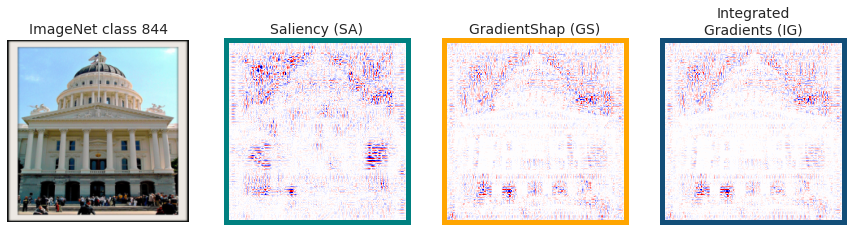

In [ ]:
# Plot explanations!
index = 1
ncols = 1 + len(explanations)

for index in [1, 10, 6]:
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, int(ncols)*3))

    for i in range(ncols):

        if i == 0:
            with warnings.catch_warnings():
                image = (np.moveaxis(quantus.denormalise(x_batch[index].cpu().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1) * 255).astype(np.uint8)
                axes[0].imshow(image, vmin=0.0, vmax=1.0)
            if include_titles:
                axes[0].set_title(f"ImageNet class {y_batch[index].item()}", fontsize=14)
                axes[0].axis("off")
        
        else:
            
            xai = methods_order[i-1].split("(")[0].replace(" ", "").replace("\n", "")
            
            axes[i].imshow(quantus.normalise_by_negative(explanations[xai][index].reshape(224, 224)), cmap="seismic", vmin=-1.0, vmax=1.0)
            if include_titles:
                axes[i].set_title(f"{methods_order[i-1]}", fontsize=14)

            # Frame configs.
            axes[i].xaxis.set_visible([])
            axes[i].yaxis.set_visible([])
            axes[i].spines["top"].set_color(colours_order[i-1])
            axes[i].spines["bottom"].set_color(colours_order[i-1])
            axes[i].spines["left"].set_color(colours_order[i-1])
            axes[i].spines["right"].set_color(colours_order[i-1])
            axes[i].spines["top"].set_linewidth(5)
            axes[i].spines["bottom"].set_linewidth(5)
            axes[i].spines["left"].set_linewidth(5)
            axes[i].spines["right"].set_linewidth(5)

    plt.show();

From this visualisation, it is hard a decipher which explanation method may be preferred or most helpful in the task of explaining the Imagenet class.

## 2) Quantification with Quantus

In the following sections, we quantify the explanations through different properties and conduct sensitivity analysis.

In [ ]:
# Check what metrics are at our disposal.
for k, v in quantus.AVAILABLE_METRICS.items():
    print(k)
    for i in v:
        print(f"\t• {i}")

Faithfulness
	• Faithfulness Correlation
	• Faithfulness Estimate
	• Pixel-Flipping
	• Region Segmentation
	• Monotonicity-Arya
	• Monotonicity-Nguyen
	• Selectivity
	• SensitivityN
	• IROF
	• ROAD
	• Infidelity
	• Sufficiency
Robustness
	• Continuity Test
	• Local Lipschitz Estimate
	• Max-Sensitivity
	• Avg-Sensitivity
	• Consistency
Localisation
	• Pointing Game
	• Top-K Intersection
	• Relevance Mass Accuracy
	• Relevance Rank Accuracy
	• Attribution Localisation 
	• AUC
	• Focus
Complexity
	• Sparseness
	• Complexity
	• Effective Complexity
Randomisation
	• Model Parameter Randomisation
	• Random Logit
Axiomatic
	• Completeness
	• NonSensitivity
	• InputInvariance


### 2.1 Quantification introduction

What are some stuff we can do with Quantus?

In [ ]:
# Let's try one localisation metric.
quantus.TopKIntersection().get_params

Warnings and information:
 (1) The Top K Intersection metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch', the number of features to consider 'k', if size of the ground truth mask is taking into account 'concept_influence' as well as if attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Theiner, Jonas, Müller-Budack Eric, and Ewerth, Ralph. 'Interpretable Semantic Photo Geolocalization.' arXiv preprint arXiv:2104.14995 (2021).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



{'abs': False,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'normalise_func': <function quantus.helpers.normalise_func.normalise_by_negative(a: numpy.ndarray, normalise_axes: Union[Sequence[int], NoneType] = None, **kwargs) -> numpy.ndarray>,
 'normalise_func_kwargs': {},
 'a_axes': None,
 'k': 1000,
 'concept_influence': False}

In [ ]:
# Alternative 1. Score methods in a one-liner - by calling the metric instance.
quantus.TopKIntersection()(model=model, 
                           x_batch=x_batch, 
                           y_batch=y_batch,
                           a_batch=a_batch_saliency,
                           s_batch=s_batch.reshape(len(x_batch), 1, 224, 224).cpu().numpy(),
                           **{"device": device})

Warnings and information:
 (1) The Top K Intersection metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch', the number of features to consider 'k', if size of the ground truth mask is taking into account 'concept_influence' as well as if attributions are normalised 'normalise' (and 'normalise_func') and/ or taking absolute values of such 'abs'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Theiner, Jonas, Müller-Budack Eric, and Ewerth, Ralph. 'Interpretable Semantic Photo Geolocalization.' arXiv preprint arXiv:2104.14995 (2021).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



[0.027,
 0.658,
 0.787,
 0.597,
 0.8190000000000001,
 0.882,
 0.253,
 0.8230000000000001,
 0.997,
 0.228,
 0.883,
 0.995,
 0.266,
 0.668,
 0.14400000000000002,
 0.677,
 0.856]

In [ ]:
# Change some hyperparameters, get an aggregate score.
quantus.TopKIntersection(return_aggregate=True,
                         disable_warnings=True)(model=model, 
                           x_batch=x_batch, 
                           y_batch=y_batch,
                           a_batch=a_batch_saliency,
                           s_batch=s_batch.reshape(len(x_batch), 1, 224, 224).cpu().numpy(),
                           **{"device": device})

[0.6211764705882353]

In [ ]:
# Score all methods iteratively?
for method, attr in explanations.items():
    
    scores = quantus.TopKIntersection(
        return_aggregate=True,
        disable_warnings=True, 
        )(model=model, 
          x_batch=x_batch, 
          y_batch=y_batch,
          a_batch=attr,
          s_batch=s_batch.reshape(len(x_batch), 1, 224, 224).cpu().numpy(),
          **{"device": device})

    print(f"{method} - {scores}")

Saliency - [0.6211764705882353]
GradientShap - [0.6423529411764706]
IntegratedGradients - [0.636529411764706]


In [ ]:
# Convert it into a Pointing Game metric.
for method, attr in explanations.items():
    
    scores = quantus.TopKIntersection(
        return_aggregate=True,
        disable_warnings=True, 
        k=1
        )(model=model, 
          x_batch=x_batch, 
          y_batch=y_batch,
          a_batch=attr,
          s_batch=s_batch.reshape(len(x_batch), 1, 224, 224).cpu().numpy(),
          **{"device": device})

    print(f"{method} - {scores}")

Saliency - [0.7647058823529411]
GradientShap - [0.6470588235294118]
IntegratedGradients - [0.6470588235294118]


### 2.2 Comprehensive quantiative analysis

We use Quantus to be able to quantiatively assess the different explanation methods on various evaluation criteria.

In [ ]:
# Define XAI methods and metrics.
xai_methods = list(explanations.keys())
metrics = {
    "Robustness": quantus.AvgSensitivity(
        nr_samples=2,
        lower_bound=0.2,
        norm_numerator=quantus.fro_norm,
        norm_denominator=quantus.fro_norm,
        perturb_func=quantus.uniform_noise,
        similarity_func=quantus.difference,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Faithfulness": quantus.FaithfulnessCorrelation(
        nr_runs=10,
        subset_size=224,
        perturb_baseline="black",
        perturb_func=quantus.baseline_replacement_by_indices,
        similarity_func=quantus.correlation_pearson,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Localisation": quantus.RelevanceRankAccuracy(
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Complexity": quantus.Sparseness(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Randomisation": quantus.RandomLogit(
        num_classes=1000,
        similarity_func=quantus.ssim,
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
}

In [ ]:
# Retrieve stored 'dummy' data.
results = {
    "Saliency": {
        "Robustness": [0.023706467548275694],
        "Faithfulness": [0.06749252841918861],
        "Localisation": [0.5122173871263156],
        "Complexity": [0.5503504513474646],
        "Randomisation": [0.8064057449830752],
    },
    "GradientShap": {
        "Robustness": [0.034456219962414575],
        "Faithfulness": [0.04583139237937677],
        "Localisation": [0.5046252238901434],
        "Complexity": [0.6088842825604118],
        "Randomisation": [0.7366918283019923],
    },
    "IntegratedGradients": {
        "Robustness": [0.02690529538428082],
        "Faithfulness": [-0.08233498797221532],
        "Localisation": [0.5071891576864163],
        "Complexity": [0.6107274870736773],
        "Randomisation": [0.7915174357470123],
    },
}


In [ ]:
# Or, run quantification analysis!
results = {method : {} for method in xai_methods}

for method in xai_methods:
    for metric, metric_func in metrics.items():

        print(f"Evaluating {metric} of {method} method.")
        gc.collect()
        torch.cuda.empty_cache()

        # Get scores and append results.
        scores = metric_func(
            model=torchvision.models.mobilenet_v3_small(weights=True).to(device),
            x_batch=x_batch.cpu().numpy(),
            y_batch=y_batch.cpu().numpy(),
            a_batch=None,
            s_batch=s_batch.reshape(len(x_batch), 1, 224, 224).cpu().numpy(),
            device=device,
            explain_func=explainer_wrapper,
            explain_func_kwargs={
                "method": method,
                "device": device,
            },
        )
        results[method][metric] = scores

        # Empty cache.
        gc.collect()
        torch.cuda.empty_cache()


Evaluating Robustness of Saliency method.
Evaluating Faithfulness of Saliency method.
Evaluating Localisation of Saliency method.
Evaluating Complexity of Saliency method.
Evaluating Randomisation of Saliency method.
Evaluating Robustness of GradientShap method.
Evaluating Faithfulness of GradientShap method.
Evaluating Localisation of GradientShap method.
Evaluating Complexity of GradientShap method.
Evaluating Randomisation of GradientShap method.
Evaluating Robustness of IntegratedGradients method.
Evaluating Faithfulness of IntegratedGradients method.
Evaluating Localisation of IntegratedGradients method.
Evaluating Complexity of IntegratedGradients method.
Evaluating Randomisation of IntegratedGradients method.


In [ ]:
# Postprocessing of scores: to get how the different explanation methods rank across criteria.
results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        results_agg[method][metric] = np.mean(results[method][metric])

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()
df

,Robustness,Faithfulness,Localisation,Complexity,Randomisation
Saliency,0.023582,0.065222,0.512228,0.550056,0.804220
GradientShap,0.033584,0.047805,0.509027,0.610840,0.740597
IntegratedGradients,0.026751,0.083685,0.507249,0.610567,0.791525


In [ ]:
# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, df.columns != 'Robustness'].apply(lambda x: x / x.max())
df_normalised["Robustness"] = df["Robustness"].min()/df["Robustness"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Faithfulness,Localisation,Complexity,Randomisation,Robustness
Saliency,2.0,3.0,1.0,3.0,3.0
GradientShap,1.0,2.0,3.0,1.0,1.0
IntegratedGradients,3.0,1.0,2.0,2.0,2.0


In [ ]:
# Plotting configs.
sns.set(font_scale=1.5)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_titles = True
include_legend = True

In [ ]:
# Plotting specifics.
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Source code: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html.

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

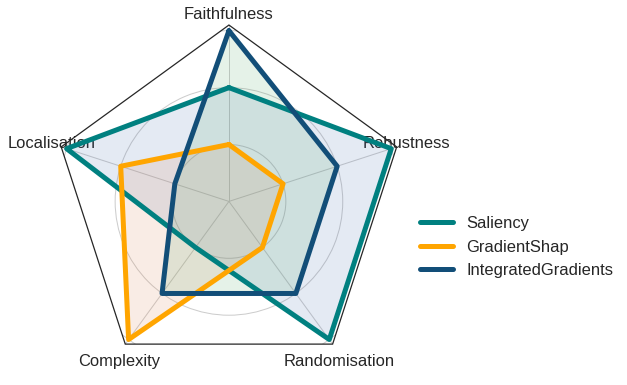

In [ ]:
# Make spyder graph!
data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = radar_factory(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods)):
    line = ax.plot(theta, d, label=method, color=colours_order[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness', 'Localisation', '\nComplexity', '\nRandomisation', 'Robustness'])
else:
    ax.set_varlabels(labels=[]) 

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[]) 

# Set a title.
#ax.set_title("Quantus: Summary of Explainer Quantification",  position=(0.5, 1.1), ha='center', fontsize=20)

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

### 2.3 Sensitivity analysis

We will investigate how much different parameters influence the evaluation outcome, i.e., how different explanations methods rank.

We use Faithfulness Correlation by Bhatt et al., 2020 for this example.

In [ ]:
# Let's list the default parameters of the metric.
quantus.FaithfulnessCorrelation().get_params

Warnings and information:
 (1) The Faithfulness Correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



{'abs': False,
 'normalise': True,
 'return_aggregate': True,
 'aggregate_func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'normalise_func': <function quantus.helpers.normalise_func.normalise_by_negative(a: numpy.ndarray, normalise_axes: Union[Sequence[int], NoneType] = None, **kwargs) -> numpy.ndarray>,
 'normalise_func_kwargs': {},
 'a_axes': None,
 'perturb_func': <function quantus.helpers.perturb_func.baseline_replacement_by_indices(arr: <built-in function array>, indices: Union[int, Sequence[int], Tuple[<built-in function array>]], indexed_axes: Sequence[int], perturb_baseline: Union[float, int, str, <built-in function array>], **kwargs) -> <built-in function array>>,
 'perturb_func_kwargs': {'perturb_baseline': 'black'},
 'similarity_func': <function quantus.helpers.similarity_func.correlation_pearson(a: <built-in function array>, b: <built-in function array>, **kwargs) -> float>,
 'nr_runs': 100,
 'subset_size': 224}

In [ ]:
# Define some parameter settings to evaluate.
baseline_strategies = ["mean", "uniform"]
subset_sizes = np.array([224,  224*10, 224*100])
sim_funcs = {"pearson": quantus.correlation_pearson, "spearman": quantus.correlation_spearman}

result = {
    "Faithfulness score": [],
    "Method": [],
    "Similarity function": [],
    "Baseline strategy": [],
    "Subset size": [],
}

In [ ]:
# Score explanations!
for b in baseline_strategies:
    for s in subset_sizes:
        for method, attr in explanations.items():
            for sim, sim_func in sim_funcs.items():
                metric = quantus.FaithfulnessCorrelation(abs=False,
                                                         normalise=True,
                                                         return_aggregate=True,
                                                         disable_warnings=True,
                                                         aggregate_func=np.mean,
                                                         normalise_func=quantus.normalise_by_negative,
                                                         nr_runs=10,
                                                         perturb_baseline=b,
                                                         perturb_func=quantus.baseline_replacement_by_indices,
                                                         similarity_func=sim_func,
                                                         subset_size=s)
                score = metric(model=model.cuda(), x_batch=x_batch.cpu().numpy(), y_batch=y_batch.cpu().numpy(), a_batch=attr, device=device)
                result["Method"].append(method)
                result["Baseline strategy"].append(b.capitalize())
                result["Subset size"].append(s)
                result["Faithfulness score"].append(score[0])
                result["Similarity function"].append(sim)

df = pd.DataFrame(result)
df.head()

,Faithfulness score,Method,Similarity function,Baseline strategy,Subset size
0,-0.025062,Saliency,pearson,Mean,224
1,-0.185740,Saliency,spearman,Mean,224
2,0.135635,GradientShap,pearson,Mean,224
3,0.118004,GradientShap,spearman,Mean,224
4,0.187899,IntegratedGradients,pearson,Mean,224


In [ ]:
# Group by the ranking.
df["Rank"] = df.groupby(['Baseline strategy', 'Subset size', 'Similarity function'])["Faithfulness score"].rank()

# Smaller adjustments.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns = map(lambda x: str(x).capitalize(), df.columns)
df.head()

,Faithfulness score,Method,Similarity function,Baseline strategy,Subset size,Rank
0,-0.025062,Saliency,pearson,Mean,224,1.0
1,-0.185740,Saliency,spearman,Mean,224,1.0
2,0.135635,GradientShap,pearson,Mean,224,2.0
3,0.118004,GradientShap,spearman,Mean,224,3.0
4,0.187899,IntegratedGradients,pearson,Mean,224,3.0


How does this relate back to our (naive) intution about how XAI methods should rank (consistently)?

In [ ]:
# Group by rank.
df_view = df.groupby(["Method"])["Rank"].value_counts(normalize=True).mul(100).reset_index(name='Percentage').round(2)
df_view = df_view.append({'Method': 'Method A', 'Rank': 1.0, 'Percentage': 100}, ignore_index=True)
df_view = df_view.append({'Method': 'Method B', 'Rank': 2.0, 'Percentage': 100}, ignore_index=True)
df_view = df_view.append({'Method': 'Method C', 'Rank': 3.0, 'Percentage': 100}, ignore_index=True)

# Reorder the methods for plotting purporses.
df_view_ordered = pd.DataFrame(columns=["Method", "Rank", "Percentage"])
df_view_ordered = df_view_ordered.append({'Method': 'Method A', 'Rank': 1.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append({'Method': 'Method B', 'Rank': 2.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append({'Method': 'Method C', 'Rank': 3.0, 'Percentage': 100}, ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'Saliency']], ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'GradientShap']], ignore_index=True)
df_view_ordered = df_view_ordered.append([df_view.loc[df_view["Method"] == 'IntegratedGradients']], ignore_index=True)
df_view_ordered

,Method,Rank,Percentage
0,Method A,1.0,100
1,Method B,2.0,100
2,Method C,3.0,100
3,Saliency,1.0,83.33
4,Saliency,2.0,16.67
5,GradientShap,3.0,58.33
6,GradientShap,2.0,41.67
7,IntegratedGradients,2.0,41.67
8,IntegratedGradients,3.0,41.67
9,IntegratedGradients,1.0,16.67


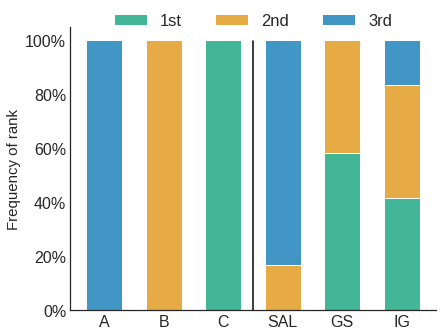

In [ ]:
# Plot results!
fig, ax = plt.subplots(figsize=(6.5,5))
ax = sns.histplot(x='Method', hue='Rank', weights='Percentage', multiple='stack', data=df_view_ordered, shrink=0.6, palette="colorblind", legend=False)
ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Frequency of rank', fontsize=15)
ax.set_xlabel('')
ax.set_xticklabels(["A", "B", "C", "SAL", "GS", "IG"])
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False, labels=['1st', "2nd", "3rd", "4th"])
plt.axvline(x=2.5, ymax=0.95, color='black', linestyle='-')
plt.tight_layout();

Contrary to intution where ranking is consistent over different metric parameterisations, the ranking significantly differ in the different experimental settings.